In [145]:
using Pkg
Pkg.activate(@__DIR__)

using Plots, StatsPlots
using Interpolations
using QuantEcon
using Parameters
using Optim
using Optim: minimum, minimizer
using TransformVariables
using FastChebInterp
using DataFrames, DataFramesMeta
using ConcreteStructs
using Roots
using ProgressMeter
using Statistics
using TexTables

  Activating project at `~/Desktop/programming_for_econ/past_papers/code_for_past_paper/julia`


In [146]:
# # Some options for interpolation 
# abstract type ContinuousInterp          end
# struct CubicSplines <: ContinuousInterp end 
# struct LinearInterp <: ContinuousInterp end 
# struct ChebyInterp  <: ContinuousInterp end 
# struct GridSearch
#     Nl::Int
# end 

# interpolant(::CubicSplines, grid, V) = cubic_spline_interpolation(grid, V)
# interpolant(::LinearInterp, grid, V) = linear_interpolation(grid, V)
# interpolant(::ChebyInterp, grid, V)  = chebinterp(V, extrema(grid)...)
# interpolant(::GridSearch, grid, V)   = throw(error(
#     "You should not be constructing an interpolant if you are doing a grid search"
# ))

In [147]:
using Interpolations

# Some options for interpolation 
abstract type ContinuousInterp end
struct CubicSplines <: ContinuousInterp end 
struct LinearInterp <: ContinuousInterp end 
struct ChebyInterp  <: ContinuousInterp end 
struct GridSearch 
    Nl::Int
end 

# Modify interpolant functions to handle extrapolation
interpolant(::CubicSplines, grid, V) = cubic_spline_interpolation(grid, V, extrapolation_bc=Line())
interpolant(::LinearInterp, grid, V) = linear_interpolation(grid, V, extrapolation_bc=Line())
interpolant(::ChebyInterp, grid, V)  = chebyshev_interpolation(grid, V, extrapolation_bc=Line())
interpolant(::GridSearch, grid, V)   = throw(error(
    "You should not be constructing an interpolant if you are doing a grid search"
))


interpolant (generic function with 4 methods)

Part a

In [148]:
"""
BewleyParams contains all of the parameters that we need to solve the
neoclassical growth model (Ramsey Model) with endogenous labour supply. 
This allows us to pass it around as a single object. 
"""
@with_kw struct BewleyParameters{T}
    β::Float64  = 0.95  
        # these type annotations (::Float64) are needed when defining a new
        # struct Julia's compiler needs to know how to lay this new object out
        # in memory
    r::Float64  = .03   
    μ::Float64  = 0.5   
    ρ::Float64  = 0.7
    σϵ::Float64 = 0.16 
    σ::Float64  = 2.5
    δ::Float64  = 0.0
    φ::Float64  = 0.0
    Na::Int     = 100
    Ny::Int     = 15
    interp_mode::T = CubicSplines()
        # Here, we've annotated the type as ::T (which also shows up in the type
        # definition: BewleyParams{T}). This means that T is a type parameter --
        # it can take any value that we want
end
Base.broadcastable(p::BewleyParameters) = Ref(p) # makes broadcasting work properly

u(p, c) = (@unpack σ = p;  c^(1-σ)/(1-σ))

function setup(p::BewleyParameters, interp_mode::ContinuousInterp)
    @unpack Na, Ny, ρ, σϵ, μ = p 
    
    # Capital Grid 
    if interp_mode isa ChebyInterp
        agrid = chebpoints(Na-1, 0, 300)
    else
        agrid = LinRange(0, 500, Na)
    end
    
    # Discretize income grid
    mc    = rouwenhorst(Ny, ρ, σϵ, μ)
    ygrid = mc.state_values 
    P     = mc.p'

    # Setup guesses 
    V  = zeros(Na, Ny)
    V0 = zeros(Na, Ny)
    EV = zeros(Na, Ny)

    policy = (
        c = zeros(Na, Ny),
        a = zeros(Na, Ny)
    )

    return (; V, V0, EV, policy, agrid, ygrid, P)
end

function solve!(p::BewleyParameters, m; tol = 1e-8, maxiter = 1000)
    @unpack V, V0       = m
    @unpack interp_mode = p
    iter = 0 
    while true
        iter += 1 
        update_bellman!(p, m)

        err = maximum(abs.(V - V0))
        err < tol       && break
        iter >= maxiter && break

        V0 .= V
        yield()
    end

    return (; V, iter)
end


function update_bellman!(p::BewleyParameters, m)
    @unpack EV, P, V0, V, policy, agrid, ygrid = m
    @unpack interp_mode = p
    # Calculate expectations 
    EV .= V0 * P
    EV̂ = interpolant(interp_mode, (agrid, ygrid), EV) 

    Threads.@threads for zy in eachindex(ygrid)
        # Interpolate along each income slice of the grid 

        # Solve the inner problem for each point on the asset grid
        for za in eachindex(agrid)
            @unpack v′, c, a = solve_inner(p, m, EV̂, za, zy)
            V[za, zy]           = v′
            policy.c[za, zy]    = c
            policy.a[za, zy]    = a
        end
    end
    return
end

function solve_inner(p::BewleyParameters, m, EV, za, zy)
    @unpack agrid, ygrid = m
    @unpack β, r, φ, δ, interp_mode   = p
    a = agrid[za]
    y = exp(ygrid[zy])
    z = (1+r) * a + y 
    EV̂ = interpolant(interp_mode, (agrid, ygrid), EV)

    obj(a′) = u(p, z - a′) + β * ((1-δ) * EV(a′, ygrid[zy]) + δ * EV(a′, φ * ygrid[zy]))
    lb      = 0.0                    # ensure a′ ≥ a̲
    ub      = min(z - 1e-6, maximum(agrid))     # ensure c ≥ 1e-6, a′ ≤ a̅
    res     = optimize(a′ -> - obj(a′), lb, ub)

    v′      = - minimum(res)
    a′      = minimizer(res)
    c       = z - a′

    return (; v′, c, a = a′)
end

setup(p) = setup(p, p.interp_mode)


setup (generic function with 2 methods)

408.371424 seconds (88.02 M allocations: 87.954 GiB, 0.88% gc time, 0.11% compilation time)
394.282703 seconds (87.58 M allocations: 87.936 GiB, 0.76% gc time)


[ Info: Saved animation to /home/reuben/Desktop/programming_for_econ/past_papers/code_for_past_paper/julia/animation.gif


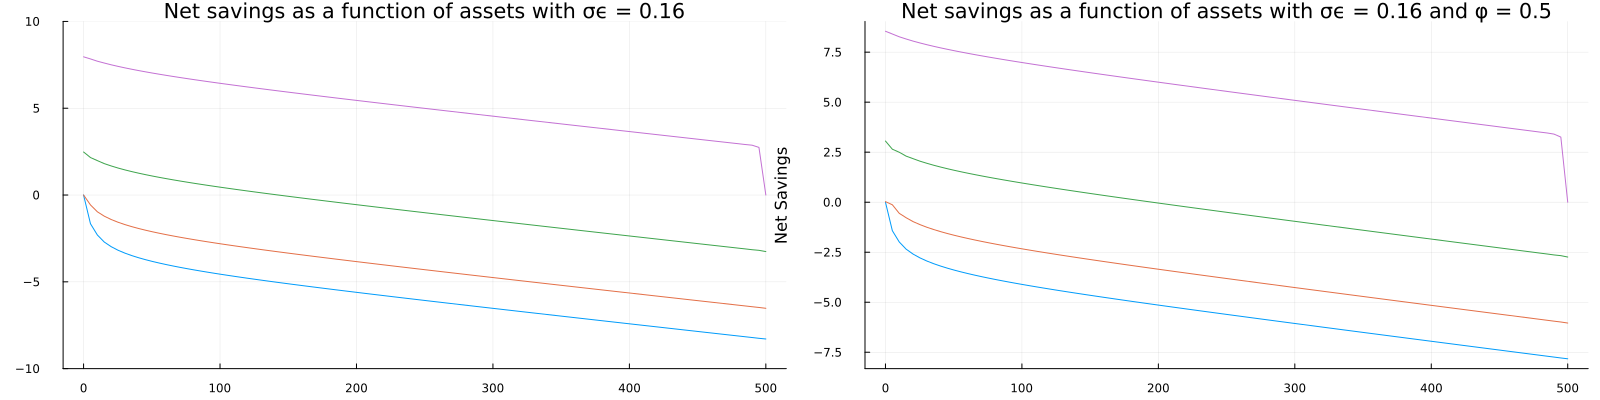

In [149]:
p = BewleyParameters(Ny = 30, σϵ = 0.05)
m = setup(p)
@time solve!(p, m);
yvals = collect(1:4) .* div(p.Ny, 4)
plt1 = plot(m.agrid, m.policy.a[:, yvals] .- m.agrid,
title = "Net savings as a function of assets with σϵ = 0.05", legend = false,
xlabel = "Assets", ylabel = "Net Savings")

p = BewleyParameters(Ny = 30, σϵ = 0.16)
m = setup(p)
@time solve!(p, m);
yvals = collect(1:4) .* div(p.Ny, 4)
plt2 = plot(m.agrid, m.policy.a[:, yvals] .- m.agrid,
title = "Net savings as a function of assets with σϵ = 0.16", legend = false,
xlabel = "Assets", ylabel = "Net Savings")
ylims!(plt1, -10, 10)
ylims!(plt2, -10, 10)

anim = @animate for i in 1:3
    if i == 1
        plot(plt1)
    elseif i == 2
        plot(plt2)
    end
end

plot(plt2, plt3, size=(1600,400))

[ Info: Saved animation to /home/reuben/Desktop/programming_for_econ/past_papers/code_for_past_paper/julia/animation.gif


Plots.AnimatedGif("/home/reuben/Desktop/programming_for_econ/past_papers/code_for_past_paper/julia/animation.gif")
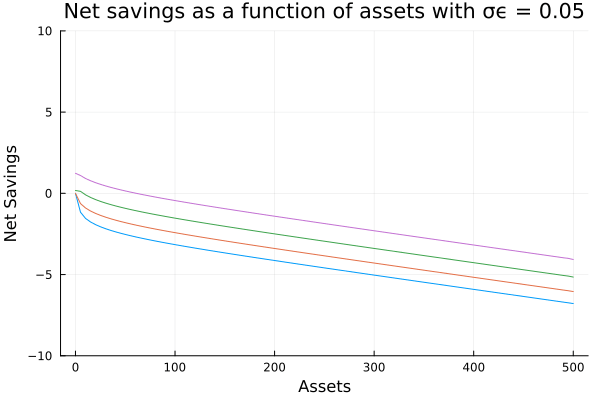

In [154]:
gif(anim, "animation.gif", fps = 1)


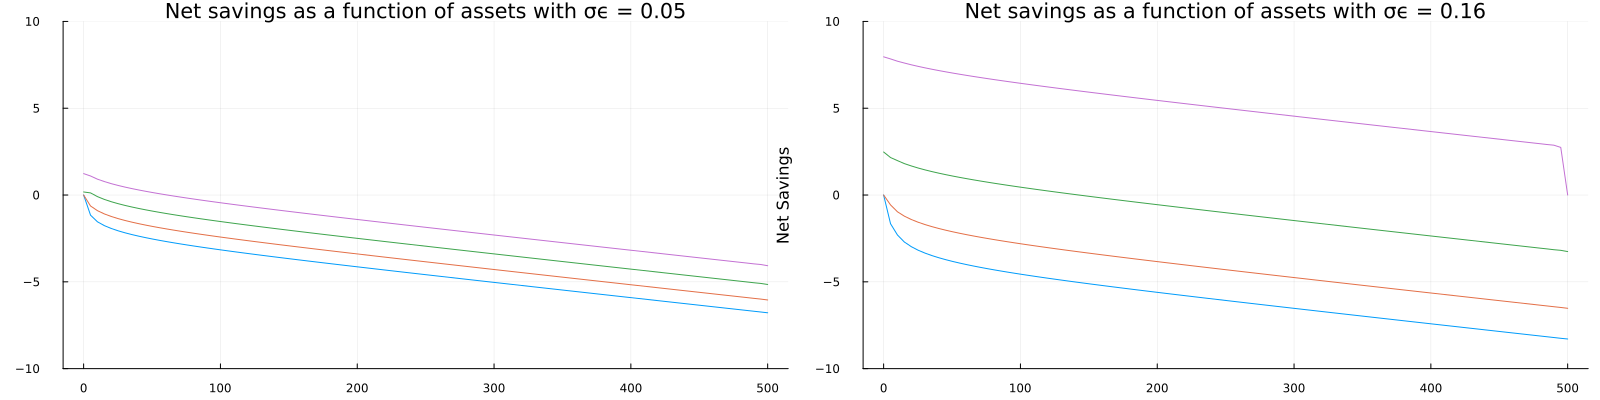

In [150]:
plot(plt1, plt2, layout=(1, 2), size=(1600, 400))

Part b

350.861964 seconds (88.45 M allocations: 88.803 GiB, 0.87% gc time)


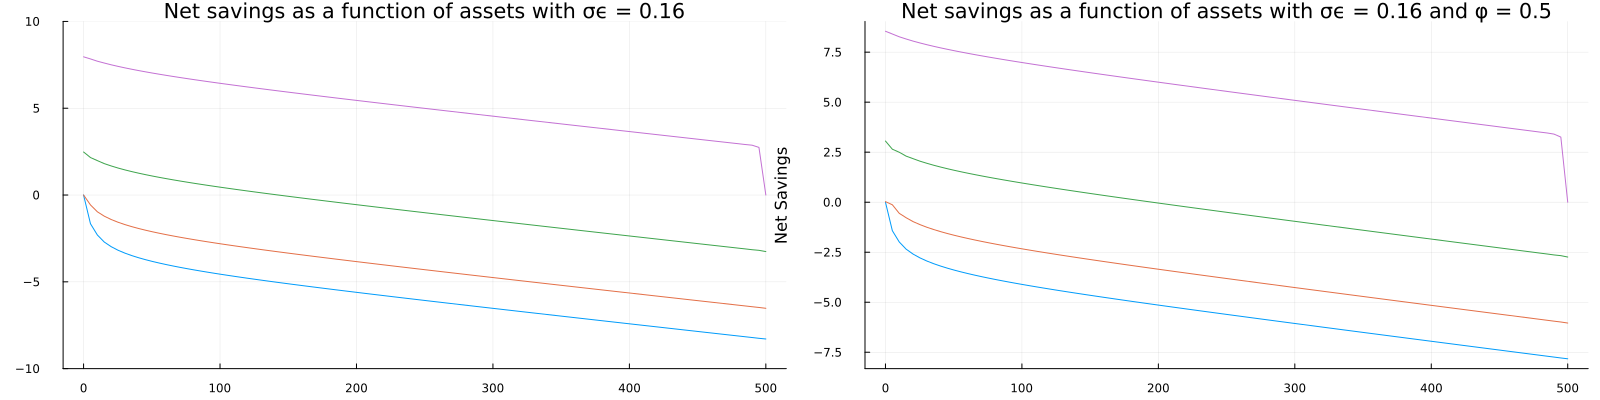

In [151]:
p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = 0.05, φ = 0.5)
m = setup(p)
@time solve!(p, m);

yvals = collect(1:4) .* div(p.Ny, 4)
plt3 = plot(m.agrid, m.policy.a[:, yvals] .- m.agrid,
title = "Net savings as a function of assets with σϵ = 0.16 and φ = 0.5", legend = false,
xlabel = "Assets", ylabel = "Net Savings")
ylims!(plt1, -10, 10)

plot(plt2, plt3, size=(1600,400))

Part c

In [152]:
function simulated(p::BewleyParameters, m; N = 10_000, T = 1000)
    @unpack agrid, ygrid, policy, P = m
    # mc = rouwenhorst(p.Ny, p.ρ, p.σϵ)
    a  = ones(N) * mean(extrema(agrid))
    y  = ones(N) * ygrid[div(length(ygrid), 2)]
    Pc = cumsum(P, dims=1)
    
    # To produce them all at once
    # y = reshape(QuantEcon.simulate(m.mc, N * T), N, T)

    â = LinearInterpolation((agrid, ygrid), policy.a)
    ĉ = LinearInterpolation((agrid, ygrid), policy.c)

    for t in 1:T
        Threads.@threads for i in 1:N
            # Step assets forward 
            a′   = â(a[i], y[i])
            a[i] = a′
            
            # Step income forward (random draw from our process)
            z    = rand()
            yi   = searchsortedfirst(ygrid, y[i]) 
            yi′  = @views searchsortedfirst(Pc[:, yi], z)  
            y[i] = ygrid[yi′]
        end
    end

    return (; a, y, c = ĉ.(a, y))
end

simulated (generic function with 1 method)

332.656551 seconds (87.58 M allocations: 87.936 GiB, 0.85% gc time)
349.171789 seconds (87.58 M allocations: 87.936 GiB, 0.80% gc time)
358.955070 seconds (87.58 M allocations: 87.936 GiB, 0.87% gc time)
351.455929 seconds (87.58 M allocations: 87.936 GiB, 0.80% gc time)
356.152887 seconds (88.45 M allocations: 88.803 GiB, 0.86% gc time)
356.007579 seconds (88.45 M allocations: 88.803 GiB, 0.82% gc time)
359.031737 seconds (88.16 M allocations: 88.514 GiB, 0.79% gc time)
356.678561 seconds (88.16 M allocations: 88.514 GiB, 0.87% gc time)
362.078824 seconds (90.47 M allocations: 90.828 GiB, 0.81% gc time)
358.620962 seconds (90.18 M allocations: 90.539 GiB, 0.87% gc time)
354.997573 seconds (89.60 M allocations: 89.960 GiB, 0.82% gc time)
352.771402 seconds (89.31 M allocations: 89.671 GiB, 0.79% gc time)
360.533700 seconds (91.62 M allocations: 91.985 GiB, 0.89% gc time)
357.974171 seconds (91.04 M allocations: 91.407 GiB, 0.81% gc time)
357.447729 seconds (90.47 M allocations: 90.828 

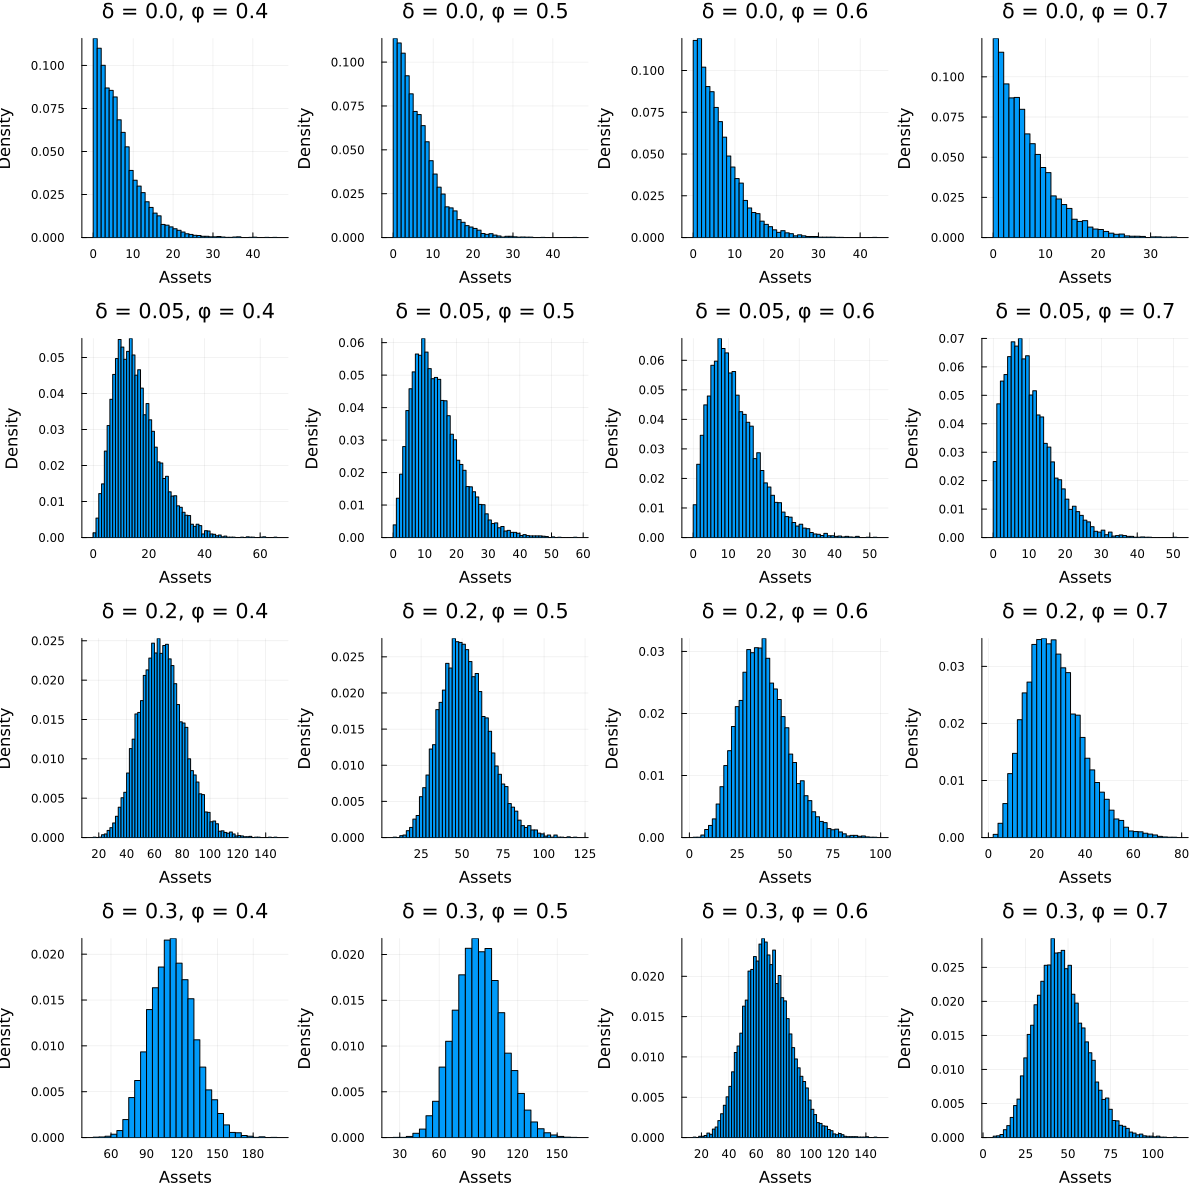

In [153]:

δ_vals = [0.0, 0.05, 0.2, 0.3]
φ_vals = [0.4, 0.5, 0.6, 0.7]
plts = []

for δ in δ_vals
    for φ in φ_vals
        p = BewleyParameters(Ny = 30, σϵ = 0.16, δ = δ, φ = φ)
        m = setup(p)
        @time solve!(p, m)
        df = simulated(p, m, T = 1000) |> DataFrame
        plt = histogram(df.a,
            xlabel = "Assets",
            ylabel = "Density",
            normed = true,
            title  = "δ = $δ, φ = $φ",
            legend = false
        )
        push!(plts, plt)
    end
end
plot(plts..., size = (1200, 1200))